Yao has suggested that it would be interesting to look at how the 2DHOD (Mass and Concentration or perhaps another parameter) vary with cosmology. I'm going to make a SHAM for Chinchilla and Aardvark and make those plots. 

In [197]:
import numpy as np
from scipy.stats import binned_statistic
from pearce.mocks import compute_prim_haloprop_bins, cat_dict
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.mock_observables import hod_from_mock, tpcf

from AbundanceMatching import *

In [198]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle

In [199]:
def correct_little_h(catalog, h):
    #apply common little h corrections to the catalogs
    for distance in ['halo_x', 'halo_y', 'halo_z']:
        catalog[distance]*=h
        
    for mass in ['halo_mvir', 'halo_mvir_host_halo']:
        catalog[mass]*=h


In [200]:
simnames = ['chinchilla', 'aardvark']
cosmo_params = { 'Lbox':400.0}

min_ptcl = 200

halocats = {}
hs = {}

for simname, scale_factor in zip(simnames, [1.0, 1.0]):
    cosmo_params['simname'] = simname
    cosmo_params['scale_factors'] = [scale_factor]
    cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

    cat.load_catalog(scale_factor)
    
    halocats[simname] = cat.halocat.halo_table[cat.halocat.halo_table['halo_mvir'] >= min_ptcl*cat.pmass]
    hs[simname] = cat.h
    
    correct_little_h(halocats[simname], cat.h)

In [201]:
np.log10(cat.pmass*cat.h*200)

10.8416120512482

In [202]:
halocats['chinchilla'].colnames

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_rvir',
 'halo_vpeak',
 'halo_rs_klypin',
 'halo_snapnum',
 'halo_halfmass_scale',
 'halo_id',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_hostid',
 'halo_mvir_host_halo']

In [203]:
lf = np.genfromtxt('/u/ki/swmclau2/des/AB_tests/lf_r_sersic_r.dat', skip_header=True)


In [204]:
af = AbundanceFunction(lf[:,1], lf[:,2],(-26, -12), )

scatter = 0.2
remainder = af.deconvolute(scatter*LF_SCATTER_MULT, 20)

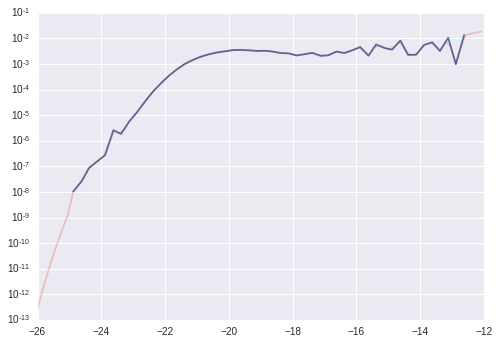

In [205]:
plt.semilogy(lf[:,1], lf[:,2])
x = np.linspace(-26, -10, 101)
plt.semilogy(x, af(x), color = 'r', alpha = 0.2)


In [206]:
galcats = {}
mag_cut = -20
scatter = 0.2

for simname in simnames:
    # TODO not sure if this little h conversion of this luminosity function is correct. If I revist this I have to 
    # double check this more clo
    #af = AbundanceFunction(lf[:,1], lf[:,2]/(hs[simname]**2),(-26, -12), )

    remainder = af.deconvolute(scatter*LF_SCATTER_MULT, 20)
    nd_halos = calc_number_densities(halocats[simname]['halo_vpeak'], hs[simname]*cat.Lbox) #don't think this matters which one i choose here

    am_catalog = af.match(nd_halos, scatter*LF_SCATTER_MULT)
    halocats[simname]['halo_vpeak_mag'] = am_catalog-5*np.log10(hs[simname])

    galcats[simname] = halocats[simname][halocats[simname]['halo_vpeak_mag'] < mag_cut]

In [207]:
5*np.log10(hs[simname])

-0.68338569939772054

In [208]:
for galcat in galcats.itervalues():
    print len(galcat)

73375
61372


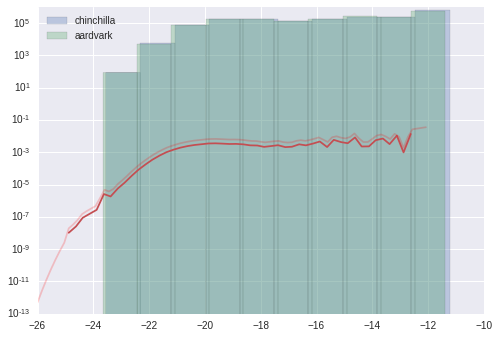

In [209]:
for simname in simnames:
    plt.hist(halocats[simname]['halo_vpeak_mag'][~np.isnan(halocats[simname]['halo_vpeak_mag'])]\
             , alpha = 0.3, label = simname)
    
plt.semilogy(lf[:,1], lf[:,2])
x = np.linspace(-26, -10, 101)
plt.semilogy(x, af(x), color = 'r', alpha = 0.2)

    
plt.yscale('log')
    
plt.legend(loc='best')

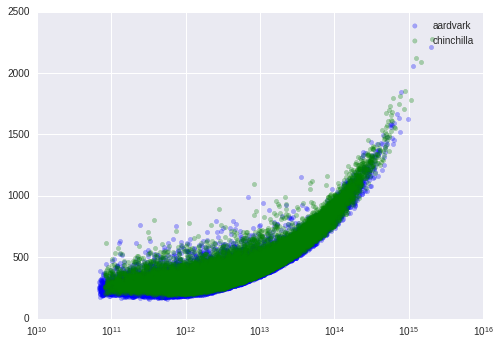

In [210]:
for (simname, galcat), color in zip(galcats.iteritems(), ('b','g')):
    plt.scatter(galcat['halo_mvir'], galcat['halo_vpeak'], label = simname, alpha = 0.3, color = color)
    
plt.xscale('log')
plt.legend(loc='best')

In [211]:
print len(galcats['chinchilla'])/((cat.h*cat.Lbox)**3)

0.00246502723531


In [212]:
print len(galcats['aardvark'])/((cat.h*cat.Lbox)**3)

0.00294713180915


In [213]:
print min(galcats['chinchilla']['halo_vpeak_mag'])

-23.550418789


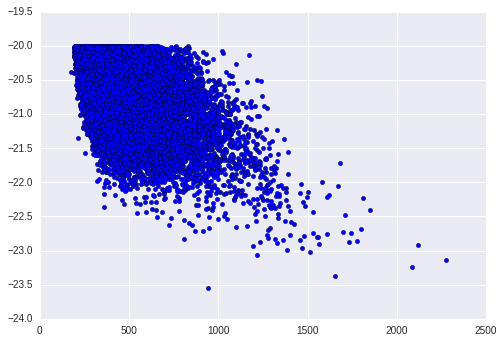

In [214]:
plt.scatter(galcats['chinchilla']['halo_vpeak'],galcats['chinchilla']['halo_vpeak_mag'])

In [215]:
from collections import Counter
def compute_occupations(halo_catalog, galaxy_catalog):
    #halo_table = cat.halocat.halo_table[cat.halocat.halo_table['halo_mvir'] > min_ptcl*cat.pmass]

    cens_occ = np.zeros((np.sum(halo_catalog['halo_upid'] == -1),))
    #cens_occ = np.zeros((len(halo_table),))
    sats_occ = np.zeros_like(cens_occ)
    detected_central_ids = set(galaxy_catalog[galaxy_catalog['halo_upid']==-1]['halo_id'])
    detected_satellite_upids = Counter(galaxy_catalog[galaxy_catalog['halo_upid']!=-1]['halo_upid'])

    for idx, row  in enumerate(halo_catalog[halo_catalog['halo_upid'] == -1]):
        cens_occ[idx] = 1.0 if row['halo_id'] in detected_central_ids else 0.0
        sats_occ[idx]+= detected_satellite_upids[row['halo_id']]

    return cens_occ, sats_occ

In [216]:
from math import ceil
def compute_mass_bins(prim_haloprop, dlog10_prim_haloprop=0.05):   
    lg10_min_prim_haloprop = np.log10(np.min(prim_haloprop))-0.001
    lg10_max_prim_haloprop = np.log10(np.max(prim_haloprop))+0.001
    num_prim_haloprop_bins = (lg10_max_prim_haloprop-lg10_min_prim_haloprop)/dlog10_prim_haloprop
    return np.logspace(
        lg10_min_prim_haloprop, lg10_max_prim_haloprop,
        num=int(ceil(num_prim_haloprop_bins)))

In [217]:
cens_occs, sats_occs = [],[]
for simname in simnames:
    cens_occ, sats_occ = compute_occupations(halocats[simname], galcats[simname])
    cens_occs.append(cens_occ)
    sats_occs.append(sats_occ)

In [218]:
host_halo_masses = []
for simname in simnames:
    host_halo_mass = halocats[simname][ halocats[simname]['halo_upid']==-1]['halo_mvir']
    host_halo_masses.append(host_halo_mass)
mass_bins = compute_mass_bins(host_halo_masses[0], 0.2)
mass_bin_centers = (mass_bins[1:]+mass_bins[:-1])/2.0
print mass_bins.shape

(22,)


In [219]:
cen_hods, sat_hods = [],[]

for simname in simnames:

    cenmask = galcats[simname]['halo_upid']==-1
    satmask = galcats[simname]['halo_upid']>0

    halo_mass = halocats[simname]['halo_mvir']

    cen_hod = hod_from_mock(galcats[simname]['halo_mvir_host_halo'][cenmask], halo_mass, mass_bins)[0]
    sat_hod = hod_from_mock(galcats[simname]['halo_mvir_host_halo'][satmask], halo_mass, mass_bins)[0]
    
    cen_hods.append(cen_hod)
    sat_hods.append(sat_hod)


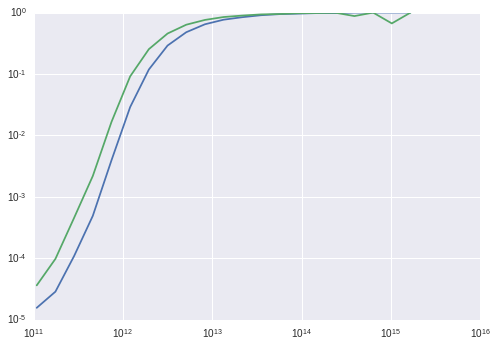

In [220]:
for cen_hod in cen_hods:
    plt.plot(mass_bin_centers, cen_hod)
plt.loglog();

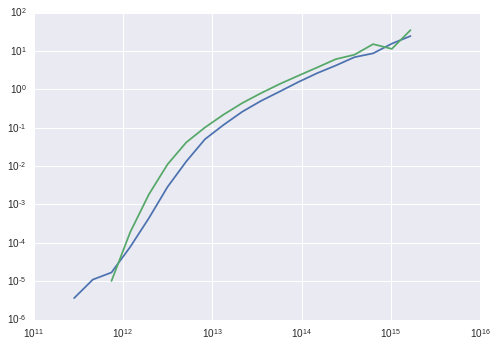

In [221]:
for sat_hod in sat_hods:
    plt.plot(mass_bin_centers, sat_hod)
plt.loglog();

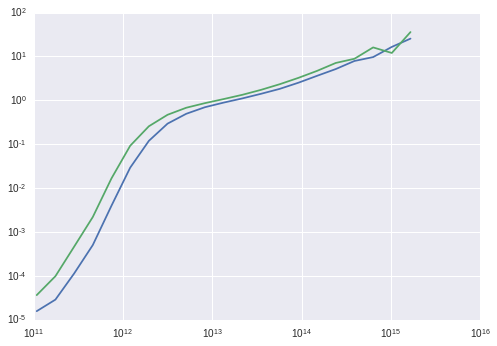

In [222]:
from itertools import izip
for cen_hod, sat_hod in izip(cen_hods, sat_hods):
    plt.plot(mass_bin_centers, cen_hod+sat_hod)
plt.loglog();

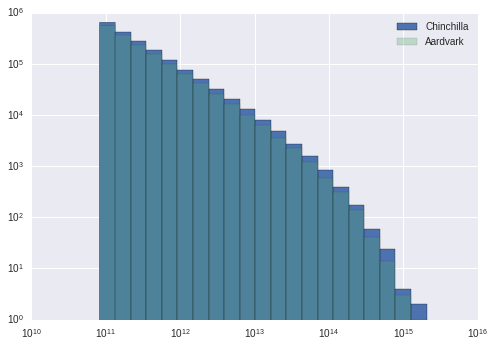

In [223]:
plt.hist(halocats['chinchilla']['halo_mvir'], bins = mass_bins, label = 'Chinchilla')
plt.hist(halocats['aardvark']['halo_mvir'], bins = mass_bins, alpha = 0.3, label = 'Aardvark');
plt.legend(loc = 'best')
plt.yscale('log')
plt.xscale('log')
#plt.loglog()

In [224]:
rbins = np.logspace(-1, 1.7, 15)
rpoints = (rbins[1:]+rbins[:-1])/2

In [225]:
nd = 1e-3
n_obj_needed = int(nd*(cat.Lbox**3))
halo_clusterings = {}
for simname, halocat in halocats.iteritems():
    sort_idxs = np.argsort(halocat['halo_mvir'])
    tmp_halocat = halocat[sort_idxs[-1*n_obj_needed:]]
    
    print np.min(tmp_halocat['halo_mvir'])
    
    pos = np.c_[tmp_halocat['halo_x'], tmp_halocat['halo_y'], tmp_halocat['halo_z']]
    halo_clusterings[simname] = tpcf(pos, rbins, period=cat.Lbox)
    

2.50536e+12
3.1528e+12


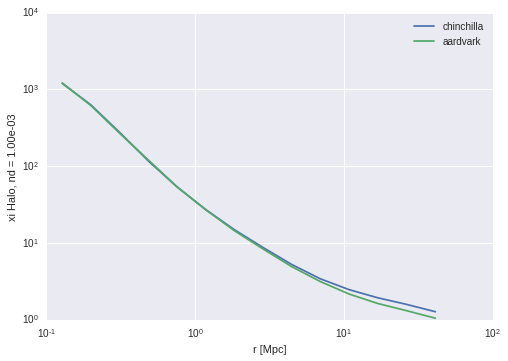

In [226]:
for simname in simnames:
    plt.plot(rpoints, halo_clusterings[simname], label = simname)

plt.loglog();
plt.legend(loc='best')
plt.xlabel('r [Mpc]')
plt.ylabel('xi Halo, nd = %.2e'%nd)

In [227]:
pos = np.c_[galcats['chinchilla']['halo_x'], galcats['chinchilla']['halo_y'], galcats['chinchilla']['halo_z']]
chin_xi = tpcf(pos, rbins, period=cat.Lbox)

In [228]:
pos = np.c_[galcats['aardvark']['halo_x'], galcats['aardvark']['halo_y'], galcats['aardvark']['halo_z']]
aard_xi = tpcf(pos, rbins, period=cat.Lbox)

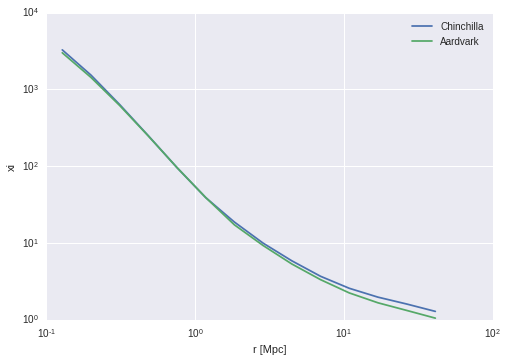

In [229]:
plt.plot(rpoints, chin_xi, label = 'Chinchilla')
plt.plot(rpoints, aard_xi, label = 'Aardvark')

plt.loglog();
plt.legend(loc='best')
plt.xlabel('r [Mpc]')
plt.ylabel('xi')

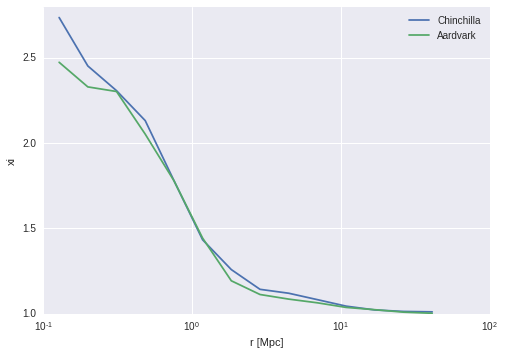

In [230]:
plt.plot(rpoints, chin_xi/halo_clusterings['chinchilla'], label = 'Chinchilla')
plt.plot(rpoints, aard_xi/halo_clusterings['aardvark'], label = 'Aardvark')

#plt.loglog();
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('r [Mpc]')
plt.ylabel('xi')

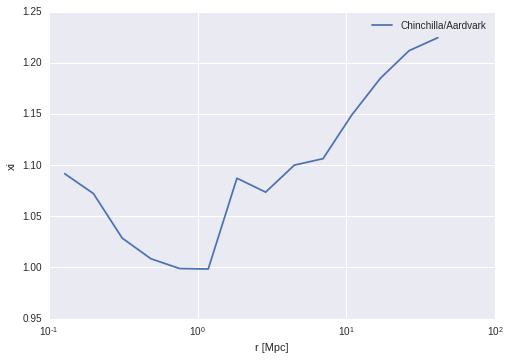

In [231]:
plt.plot(rpoints, chin_xi/aard_xi, label = 'Chinchilla/Aardvark')
#plt.plot(rpoints, aard_xi, label = 'Aardvark')

#plt.loglog();
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('r [Mpc]')
plt.ylabel('xi')

In [232]:
conc_bins = np.linspace(0, 1, 10)#np.linspace(0, 1000, 10)#np.linspace(0, 22, 10)

In [233]:
#sns.set_palette(sns.diverging_palette(255, 133, l=60, n=22, center="light"))
colors =sns.cubehelix_palette(22,start=.5, rot=-.75)

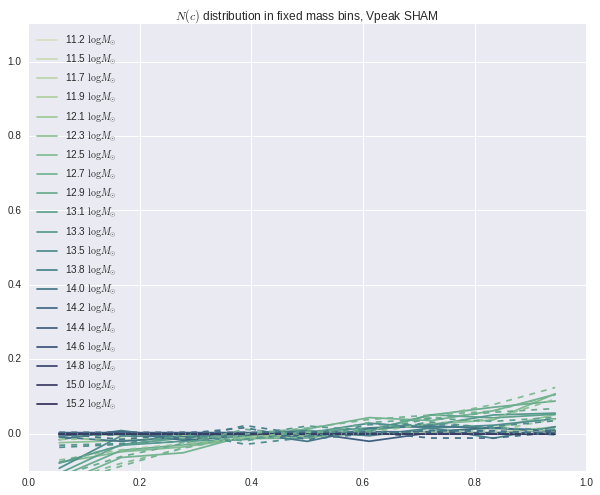

In [234]:
i = 0
fig = plt.figure(figsize = ((10,8)))

for simname, host_halo_mass, cens_occ, sats_occ, ls  in izip(simnames, host_halo_masses, cens_occs, sats_occs, ['-', '--']):
    mass_bin_idxs = compute_prim_haloprop_bins(prim_haloprop_bin_boundaries=mass_bins, prim_haloprop =host_halo_mass)

    host_halo_conc =halocats[simname][ halocats[simname]['halo_upid']==-1]['halo_nfw_conc']

    conditional_conc_percentiles = compute_conditional_percentiles(prim_haloprop  = host_halo_mass,\
                                                                  sec_haloprop = host_halo_conc,\
                                                                  prim_haloprop_bin_boundaries = mass_bins)

    mass_bin_nos = range(1,21,1)
    for bin_no, c in zip(mass_bin_nos, colors):
        bin_center = np.mean(mass_bins[bin_no:bin_no+2])
        indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
        cens_avg, sats_avg = np.mean(cens_occ[indices_of_mb]), np.mean(sats_occ[indices_of_mb])

        #med_conc = np.median([indices_of_mb, 5])
        med_conc = 0.5

        (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(conditional_conc_percentiles[indices_of_mb],\
                                                                      cens_occ[indices_of_mb],bins=conc_bins), \
                                   binned_statistic(conditional_conc_percentiles[indices_of_mb],\
                                                                      sats_occ[indices_of_mb],bins=conc_bins)

        cen_bin_counts, _, _ = binned_statistic(conditional_conc_percentiles[indices_of_mb],\
                                                cens_occ[indices_of_mb], bins = conc_bins, statistic='sum')
        sat_bin_counts, _, _ = binned_statistic(conditional_conc_percentiles[indices_of_mb],\
                                                sats_occ[indices_of_mb], bins = conc_bins, statistic='sum')

        c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
        #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
        #plt.errorbar(c_bin_centers,(binned_sats-sats_avg), yerr=np.sqrt(binned_sats/sat_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
        if i >0:
            plt.plot(c_bin_centers,(binned_cens-cens_avg),color = c, ls = ls)
        else:
            plt.plot(c_bin_centers,(binned_cens-cens_avg),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center), ls = ls)
    i+=1
        
#plt.xscale('log')
plt.legend(loc='best')
#plt.xlim([0,25])
plt.ylim([-0.1,1.1])
#plt.xlim([-0.05, 1.2])
#plt.yscale('log')

plt.title(r"$N(c)$ distribution in fixed mass bins, Vpeak SHAM")
plt.show()

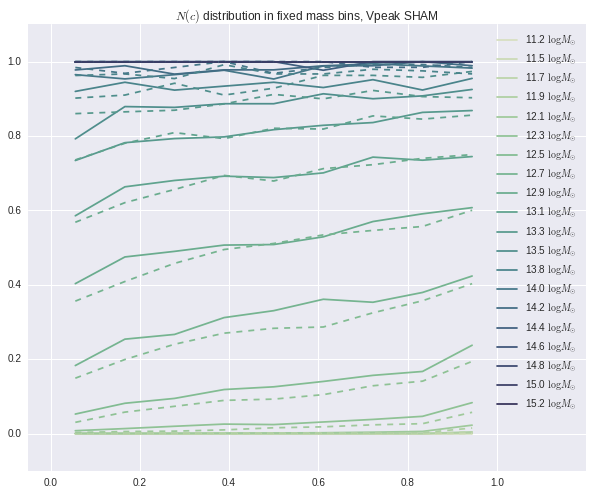

In [235]:
i = 0
fig = plt.figure(figsize = ((10,8)))

for simname, host_halo_mass, cens_occ, sats_occ, ls  in izip(simnames, host_halo_masses, cens_occs, sats_occs, ['-', '--']):
    mass_bin_idxs = compute_prim_haloprop_bins(prim_haloprop_bin_boundaries=mass_bins, prim_haloprop =host_halo_mass)

    host_halo_conc =halocats[simname][ halocats[simname]['halo_upid']==-1]['halo_nfw_conc']

    conditional_conc_percentiles = compute_conditional_percentiles(prim_haloprop  = host_halo_mass,\
                                                                  sec_haloprop = host_halo_conc,\
                                                                  prim_haloprop_bin_boundaries = mass_bins)

    mass_bin_nos = range(1,21,1)
    for bin_no, c in zip(mass_bin_nos, colors):
        bin_center = np.mean(mass_bins[bin_no:bin_no+2])
        indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
        cens_avg, sats_avg = np.mean(cens_occ[indices_of_mb]), np.mean(sats_occ[indices_of_mb])

        #med_conc = np.median([indices_of_mb, 5])
        med_conc = 0.5

        (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(conditional_conc_percentiles[indices_of_mb],\
                                                                      cens_occ[indices_of_mb],bins=conc_bins), \
                                   binned_statistic(conditional_conc_percentiles[indices_of_mb],\
                                                                      sats_occ[indices_of_mb],bins=conc_bins)

        cen_bin_counts, _, _ = binned_statistic(conditional_conc_percentiles[indices_of_mb],\
                                                cens_occ[indices_of_mb], bins = conc_bins, statistic='sum')
        sat_bin_counts, _, _ = binned_statistic(conditional_conc_percentiles[indices_of_mb],\
                                                sats_occ[indices_of_mb], bins = conc_bins, statistic='sum')

        c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
        #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
        #plt.errorbar(c_bin_centers,(binned_sats-sats_avg), yerr=np.sqrt(binned_sats/sat_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
        if i >0:
            plt.plot(c_bin_centers,(binned_cens),color = c, ls = ls)
        else:
            plt.plot(c_bin_centers,(binned_cens),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center), ls = ls)
    i+=1
        
#plt.xscale('log')
plt.legend(loc='best')
#plt.xlim([0,25])
plt.ylim([-0.1,1.1])
plt.xlim([-0.05, 1.2])
#plt.yscale('log')

plt.title(r"$N(c)$ distribution in fixed mass bins, Vpeak SHAM")
plt.show()

In [236]:
from collections import defaultdict
mass_bin_nos = range(1,21,1)
binned_censes = defaultdict(list)
cens_avgs = defaultdict(list)
bin_centers = []
for bin_no, c in zip(mass_bin_nos, colors):
    for simname, host_halo_mass, cens_occ, sats_occ, ls  in izip(simnames, host_halo_masses, cens_occs, sats_occs, ['-', '--']):
        mass_bin_idxs = compute_prim_haloprop_bins(prim_haloprop_bin_boundaries=mass_bins, prim_haloprop =host_halo_mass)

        host_halo_conc =halocats[simname][ halocats[simname]['halo_upid']==-1]['halo_nfw_conc']

        conditional_conc_percentiles = compute_conditional_percentiles(prim_haloprop  = host_halo_mass,\
                                                                      sec_haloprop = host_halo_conc,\
                                                                      prim_haloprop_bin_boundaries = mass_bins)

        bin_center = np.mean(mass_bins[bin_no:bin_no+2])
        if simname == 'chinchilla':
            bin_centers.append(bin_center)
            
        indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
        cens_avg, sats_avg = np.mean(cens_occ[indices_of_mb]), np.mean(sats_occ[indices_of_mb])
        
        cens_avgs[simname].append(cens_avg)

        #med_conc = np.median([indices_of_mb, 5])
        med_conc = 0.5

        (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(conditional_conc_percentiles[indices_of_mb],\
                                                                      cens_occ[indices_of_mb],bins=conc_bins), \
                                   binned_statistic(conditional_conc_percentiles[indices_of_mb],\
                                                                      sats_occ[indices_of_mb],bins=conc_bins)
            
        binned_censes[simname].append(binned_cens)

        cen_bin_counts, _, _ = binned_statistic(conditional_conc_percentiles[indices_of_mb],\
                                                cens_occ[indices_of_mb], bins = conc_bins, statistic='sum')
        sat_bin_counts, _, _ = binned_statistic(conditional_conc_percentiles[indices_of_mb],\
                                                sats_occ[indices_of_mb], bins = conc_bins, statistic='sum')

        c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
        #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
        #plt.errorbar(c_bin_centers,(binned_sats-sats_avg), yerr=np.sqrt(binned_sats/sat_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
        

[  0.00000000e+00   1.61269514e-05   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.45140222e-04]
1.79187064127e-05


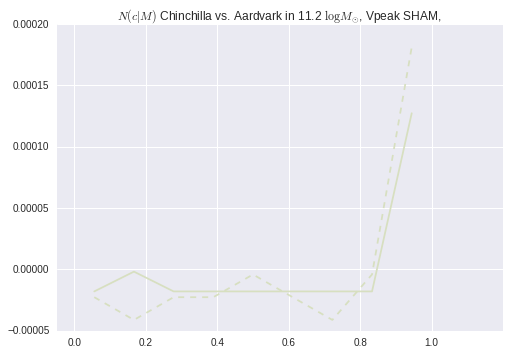

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.00029373]
3.26368094255e-05


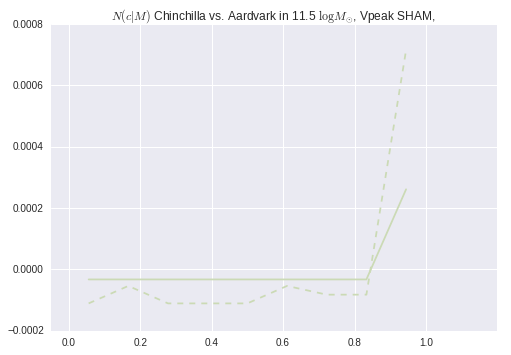

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   3.69863520e-05
   1.07256454e-03]
0.000123286826803


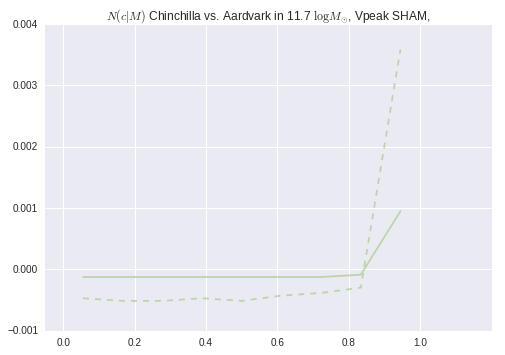

[  0.00000000e+00   0.00000000e+00   5.59190292e-05   5.59190292e-05
   5.59221564e-05   0.00000000e+00   1.11838058e-04   2.23676117e-04
   4.47352234e-03]
0.000552983938613


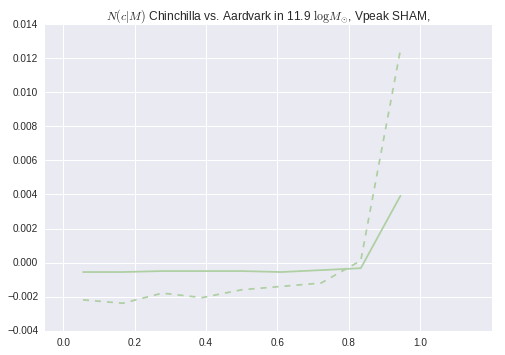

[ 0.00076453  0.00059458  0.00067958  0.00135904  0.00161386  0.00229358
  0.00382231  0.00586087  0.02267901]
0.00440757309776


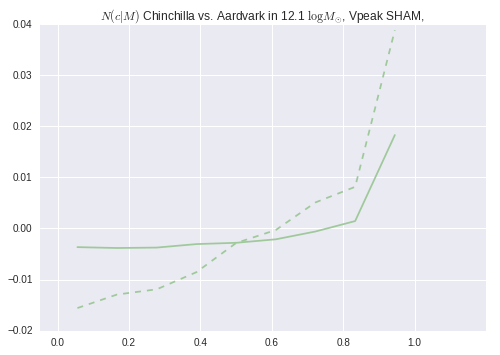

[ 0.00777706  0.01348023  0.01970188  0.02553136  0.0242385   0.03123785
  0.03810264  0.04640311  0.08320373]
0.0321869869524


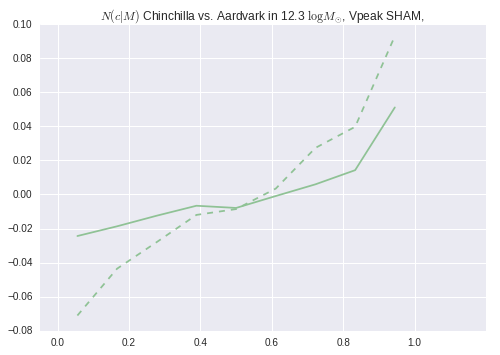

[ 0.05252765  0.08153998  0.09458926  0.11846002  0.12576505  0.14020537
  0.15656466  0.16702863  0.23751234]
0.130468167259


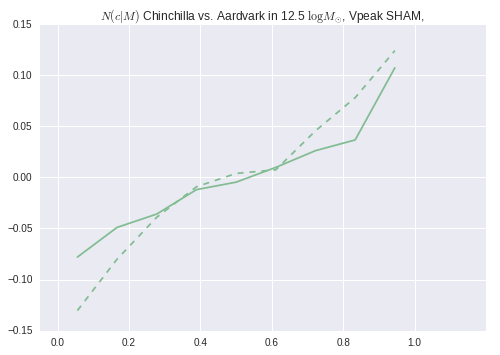

[ 0.18294574  0.25387477  0.266584    0.31184129  0.33044017  0.36112833
  0.35306882  0.37941723  0.42361326]
0.318109802301


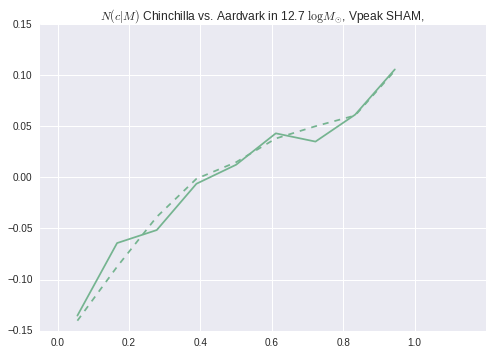

[ 0.40309328  0.47487923  0.48985507  0.50676329  0.50821256  0.52898551
  0.57004831  0.59082126  0.60743602]
0.520021470746


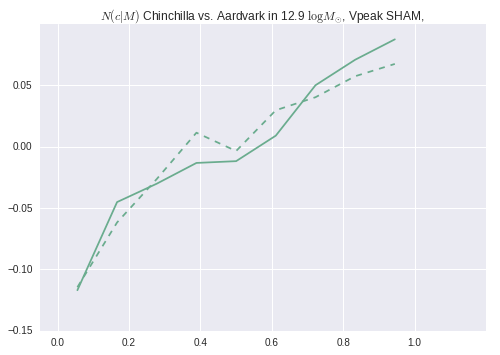

[ 0.58553127  0.66340361  0.68048229  0.69201807  0.68825301  0.70082894
  0.74322289  0.73493976  0.74472892]
0.692610260273


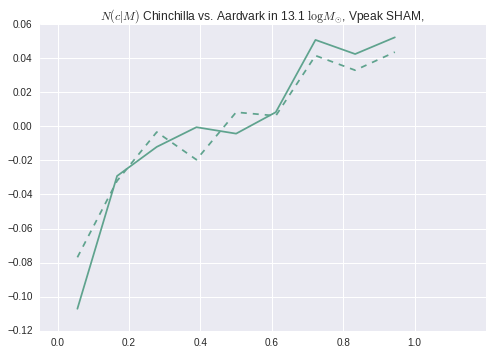

[ 0.73413174  0.78203593  0.7930622   0.79760479  0.81698565  0.82874251
  0.8361244   0.86347305  0.86842105]
0.813406038037


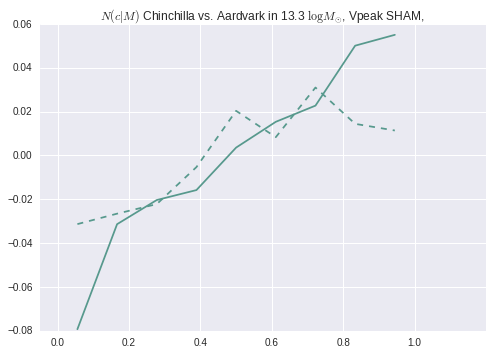

[ 0.79230769  0.87907869  0.87692308  0.88675624  0.88675624  0.91346154
  0.90019194  0.90786948  0.92514395]
0.885403329065


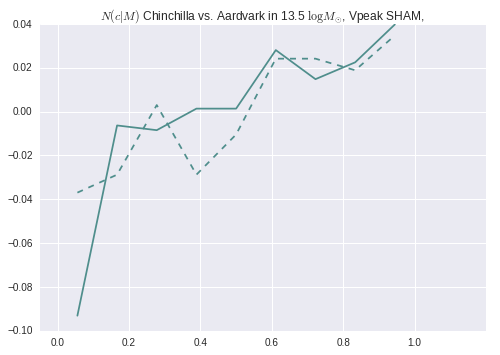

[ 0.91986063  0.94444444  0.92334495  0.93402778  0.94444444  0.93031359
  0.95138889  0.92361111  0.95486111]
0.936268829664


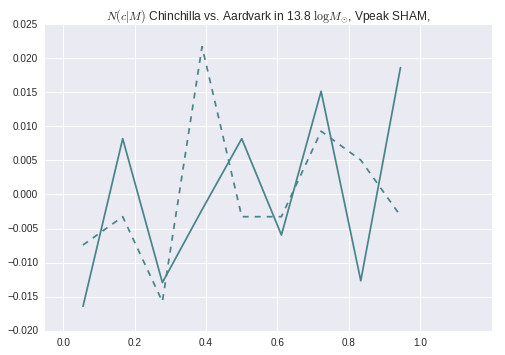

[ 0.96491228  0.95348837  0.96491228  0.97674419  0.95321637  0.98837209
  0.99415205  0.98837209  0.98255814]
0.974093264249


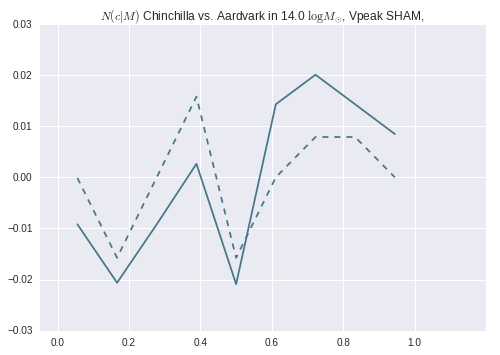

[ 0.97752809  0.98888889  0.96629213  0.97777778  0.97777778  0.98876404
  0.98888889  1.          0.98888889]
0.983890954151


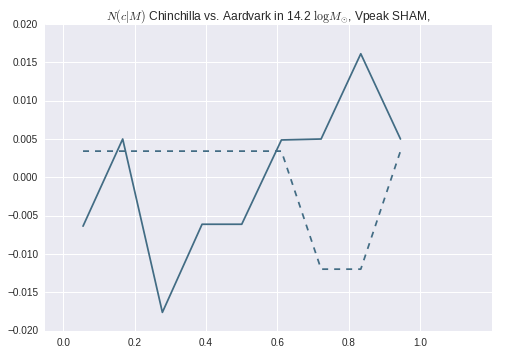

[ 1.          1.          1.          1.          1.          0.97674419
  1.          1.          1.        ]
0.997409326425


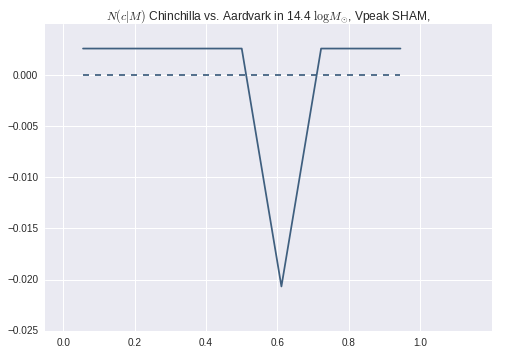

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
1.0


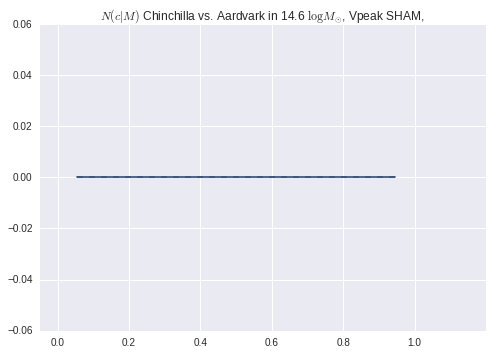

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
1.0


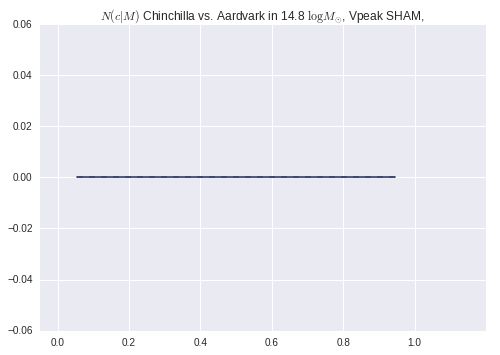

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
1.0


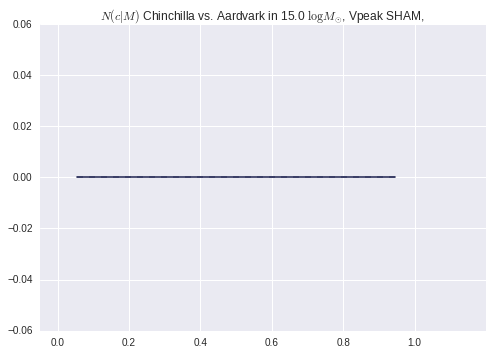

[ nan  nan   1.  nan   1.  nan   1.  nan   1.]
1.0


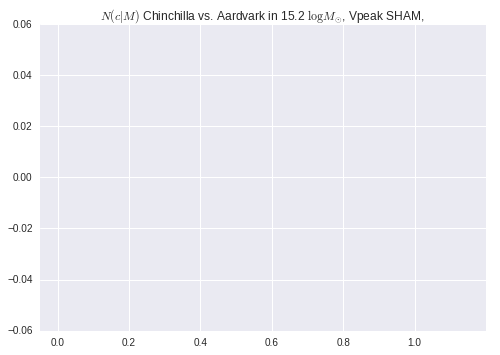

In [237]:
for binned_cens_chin, binned_cens_aard, cens_avg_chin, cens_avg_aard, bin_center, c in izip(binned_censes['chinchilla'],\
                                                                    binned_censes['aardvark'],\
                                                                    cens_avgs['chinchilla'],\
                                                                    cens_avgs['aardvark'],\
                                                                    bin_centers, 
                                                                    colors):
    
    print binned_cens_chin
    print cens_avg_chin
    plt.plot(c_bin_centers,(binned_cens_chin-cens_avg_chin),color = c)#,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    plt.plot(c_bin_centers,(binned_cens_aard-cens_avg_aard),color = c, ls = '--')
    #plt.xscale('log')
    plt.legend(loc='best')
    #plt.xlim([0,25])
    #plt.ylim([-0.1,1.1])
    plt.xlim([-0.05, 1.2])
    #plt.yscale('log')

    plt.title(r"$N(c|M)$ Chinchilla vs. Aardvark in %.1f $\log M_{\odot}$, Vpeak SHAM, "%np.log10(bin_center))
    plt.show()

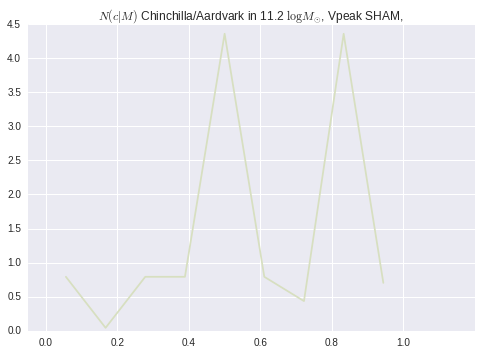

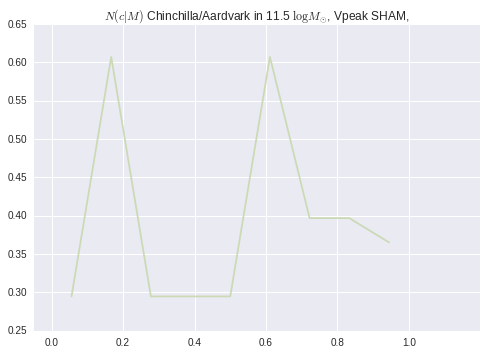

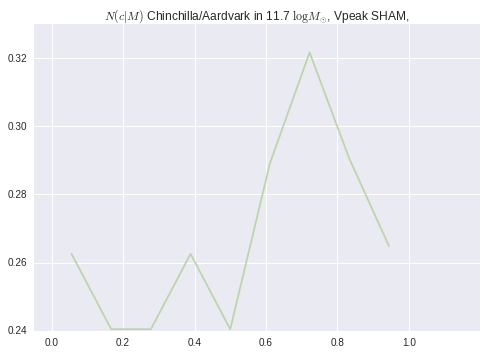

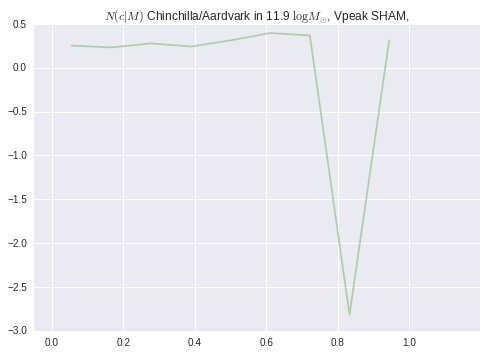

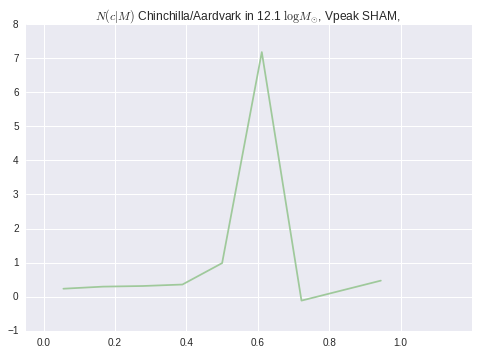

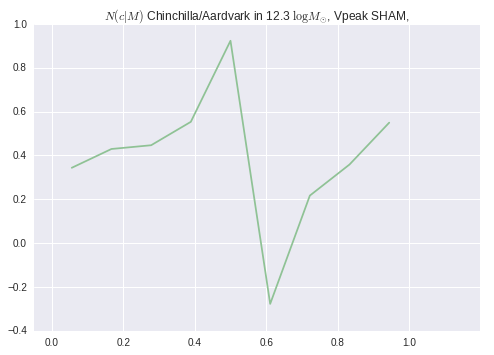

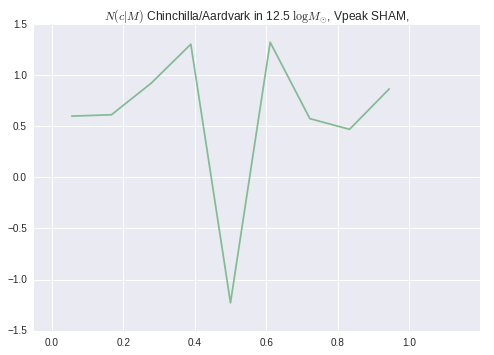

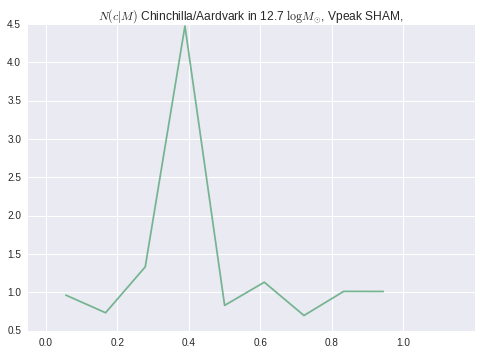

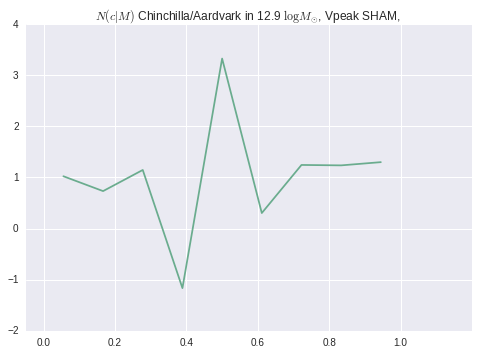

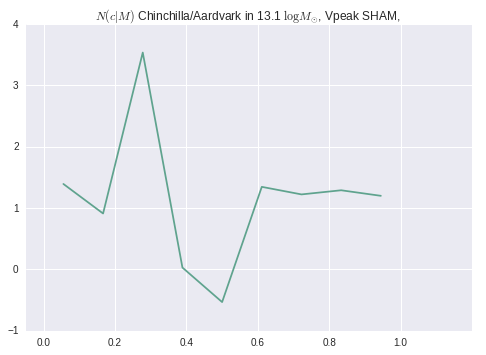

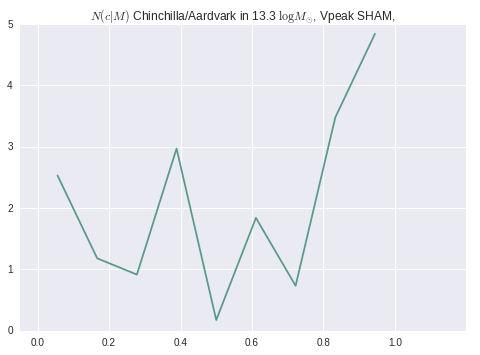

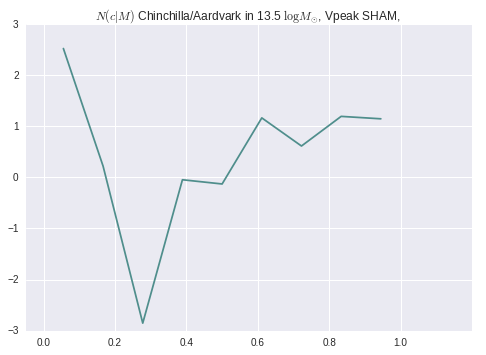

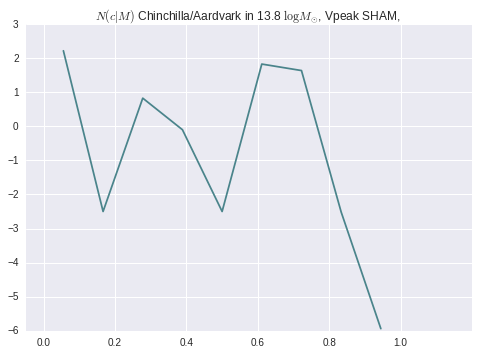

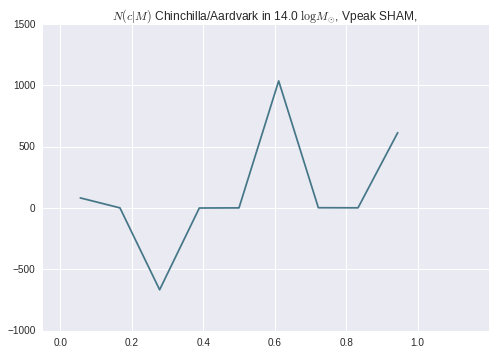

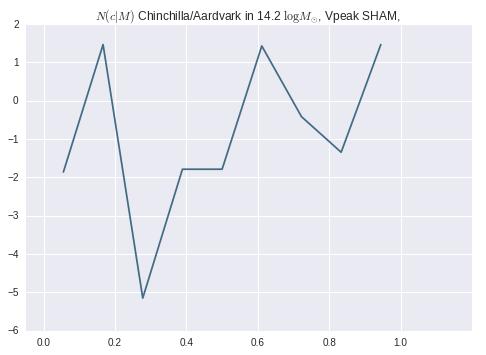

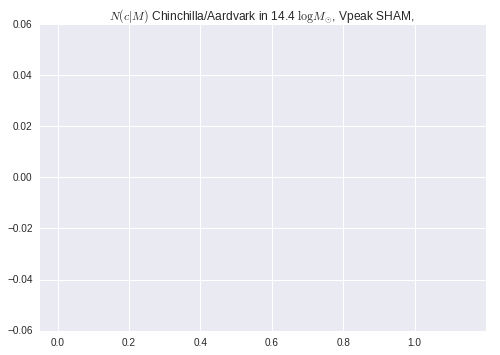

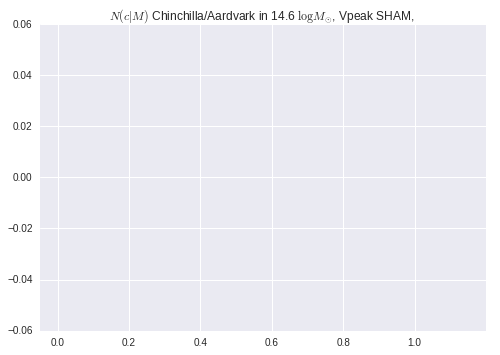

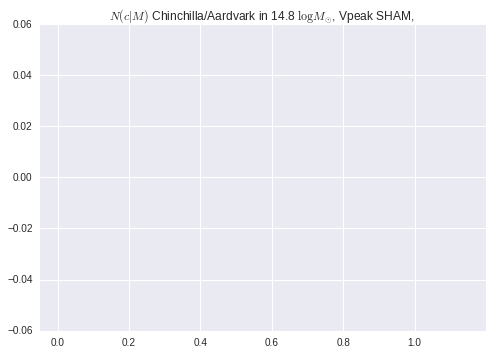

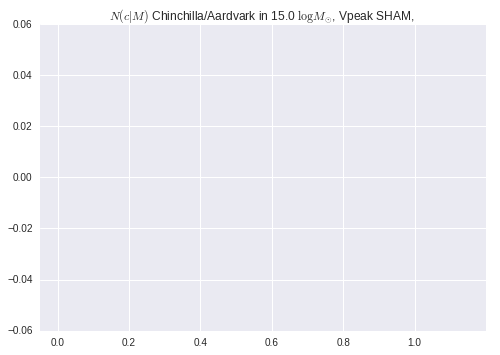

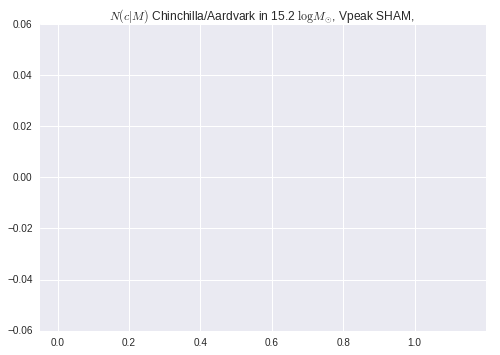

In [238]:
for binned_cens_chin, binned_cens_aard, cens_avg_chin, cens_avg_aard, bin_center, c in izip(binned_censes['chinchilla'],\
                                                                    binned_censes['aardvark'],\
                                                                    cens_avgs['chinchilla'],\
                                                                    cens_avgs['aardvark'],\
                                                                    bin_centers, 
                                                                    colors):
    plt.plot(c_bin_centers,(binned_cens_chin-cens_avg_chin)/(binned_cens_aard-cens_avg_aard),color = c)#,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))

    #plt.xscale('log')
    plt.legend(loc='best')
    #plt.xlim([0,25])
    #plt.ylim([-0.1,1.1])
    plt.xlim([-0.05, 1.2])
    #plt.yscale('log')

    plt.title(r"$N(c|M)$ Chinchilla/Aardvark in %.1f $\log M_{\odot}$, Vpeak SHAM, "%np.log10(bin_center))
    plt.show()